# IMPORTS

First the necessary imports were made.

In [1]:
import os
import cv2
import argparse
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import albumentations.augmentations.functional as F
from torchvision import models
import segmentation_models_pytorch as smp
from Utilities.Data_Retriever_Inference_Real_Time import TestDataset
from Utilities.Extract_masks import make_mask, create_filepaths
import torch.nn as nn
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline

# FUNCTIONS FOR INFERENCING

### Load Model Function

The load model loads the saved model weights and configures it for CPU inferencing.

In [2]:
def load_model(device):
    # Initialize mode and load trained weights
    ckpt_path = "./Models/model_fpn.pth"
    ENCODER = 'resnet34'
    model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=None, 
    classes=6, 
    activation=None,
    )
    #model = nn.DataParallel(model)
    model.to(device)
    model.eval()
    state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
    new_state_dict = OrderedDict()
    for k, v in state["state_dict"].items():
        name = k[7:]
        new_state_dict[name] = v
    #print(state["state_dict"])
    #print(new_state_dict)
    model.load_state_dict(new_state_dict)
    return model

### Get prediction functions

This consists of 3 functions:-

* get_prediction :- This is used to generate the prediction from the input image.
* post_process :- This function converts the predictions to masks.
* mask2rle :- This function converts the masks to RLE(Run Length Encoded) format.

In [3]:
def get_prediction(testset,model,device, best_threshold, min_size):
    # start prediction
    predictions = []
    for i, batch in enumerate(tqdm(testset)):
        fnames, images = batch
        batch_preds = torch.sigmoid(model(images.to(device)))
        batch_preds = batch_preds.detach().cpu().numpy()
        for fname, preds in zip(fnames, batch_preds):
            for cls, pred in enumerate(preds):
                pred, num = post_process(pred, best_threshold, min_size)
                rle = mask2rle(pred)
                name = fname + f"*{cls+1}"
                predictions.append([name, rle])                
    return predictions

In [4]:
def post_process(probability, threshold, min_size):
    '''Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored'''
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((128, 128), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [5]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

### Generate final output functions

This block contains the functions which reads the masks in RLE and draws the contours on the image based on the masks. The description of the functions are given below:-

* show_mask_image:- This function displays predicted masks along with the original masks in two subplots.
* name_and_mask:- This function is used to separate the masks for each defect from the RLE masks.
* generate_contours :- This function is used to draw the contours on the image based on the masks.
* show_defect_labels :- This function is used to show the colors used to mark each defects.

In [6]:
def show_mask_image(col, annot_folder, image_folder, labels, defects, palet):
    name, predicted_mask = name_and_mask(col)
    annot = os.path.join(annot_folder, (name[:-4]+'.xml'))
    actual_mask = make_mask(annot, labels)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    fig.tight_layout(pad=10.0)
    mask_type = 'actual'
    image, str3 = generate_contours(image_folder, name, mask_type, actual_mask, defects, palet)
    ax[0].set_title(name, fontsize=10) 
    ax[0].set_xlabel(str3, fontsize=10)
    ax[0].imshow(image)
    
    mask_type = 'predicted'
    image, str3 = generate_contours(image_folder, name, mask_type, predicted_mask, defects, palet)
    ax[1].set_title(name, fontsize=10) 
    ax[1].set_xlabel(str3, fontsize=10)
    ax[1].imshow(image)
    plt.show()

In [7]:
def name_and_mask(ls):
    img_names = [str(ele[0]).split("*")[0] for ele in ls]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3] ==img_names[4]==img_names[5]):
        raise ValueError

    labels = [ele[1] for ele in ls]
    mask = np.zeros((128, 128, 6), dtype=np.uint8)

    for idx, label in enumerate(labels):
        if label != '':
            mask_label = np.zeros(128*128, dtype=np.uint8)
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            for pos, le in zip(positions, length):
                mask_label[pos-1:pos+le-1] = 1
            mask[:, :, idx] = mask_label.reshape(128, 128, order='F')
    return img_names[0], mask

In [8]:
def generate_contours(image_folder, name, mask_type, mask, defects, palet):
    img = cv2.imread(os.path.join(image_folder, name))
    str1 = "This image has"
    str2 = "defect"
    multi = 0
    for ch in range(6):
        if mask_type == 'predicted':
            full_sized_mask = F.resize(mask[:, :, ch], height=200, width=200, interpolation=cv2.INTER_NEAREST)
            contours, _ = cv2.findContours(full_sized_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        else:
            contours, _ = cv2.findContours(mask[:, :, ch], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        contours=[cv2.boundingRect(cnt) for cnt in contours]
        if len(contours) > 0:
            multi = multi + 1
            if multi > 1:
                str2 = str2 + ',' + defects[ch]
            else:
                str2 = defects[ch]
        #for i in range(0, len(contours)):
            #cv2.polylines(img, contours[i], True, palet[ch], 2)
        for cnt in contours:
            x,y,w,h=cnt
            cv2.rectangle(img,(x,y),(x+w,y+h),palet[ch],2)
    if multi == 0:
        str2 = "no defect"
    str3 = str1+" "+str2+"."
    return img, str3

In [9]:
def show_defect_labels(defects, palet):
    fig, ax = plt.subplots(1, 6, figsize=(15, 5))
    for i in range(6):
        ax[i].axis('off')
        ax[i].imshow(np.ones((30, 30, 3), dtype=np.uint8) * palet[i])
        ax[i].set_title(defects[i])
    fig.suptitle("Each defect class colors")
    plt.show()

### Main function

This function combines all the above functions to get the prediction and show the comparison of the original mask and the predicted mask per image in the Validation_Images folder. 

In [10]:
def main():
    #arg_parser = argparse.ArgumentParser(description='List the content of a folder')
    # Add the arguments
    #arg_parser.add_argument('Path',
                       #metavar='path',
                       #type=str,
                       #help='File Path')
    #args = arg_parser.parse_args()
    test_image_folder = ".\Validation_Images"
    test_annot_folder = ".\Validation_Annotations"
    defects = ["crazing","patches","inclusion","pitted_surface","rolled-in_scale","scratches"]
    palet = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249,50,12), (0,255,0), (255,165,0)]
    show_defect_labels(defects, palet)
    df = create_filepaths(test_annot_folder)
    for idx in df.index:
        fname = df.iloc[idx][0] + '.jpg'
        labels = df.iloc[idx][1:7].to_dict()
        #fname = args.Path
        #print('Enter the image name:')
        #fname = input()
        #fname = "patches_151.jpg"
        # initialize test dataloader
        best_threshold = 0.5
        num_workers = 2
        batch_size = 1
        #print('best_threshold', best_threshold)
        min_size = 200
        mean = (0.485, 0.456, 0.406)
        std = (0.229, 0.224, 0.225)
        testset = DataLoader(
            TestDataset(test_image_folder, fname, mean, std),
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=True
        )
        device = torch.device("cpu")
        model = load_model(device)
        predictions = get_prediction(testset,model,device,best_threshold, min_size)
        show_mask_image(predictions, test_annot_folder, test_image_folder, labels, defects, palet)

# INFERENCING

The main function is called to generate the inference.

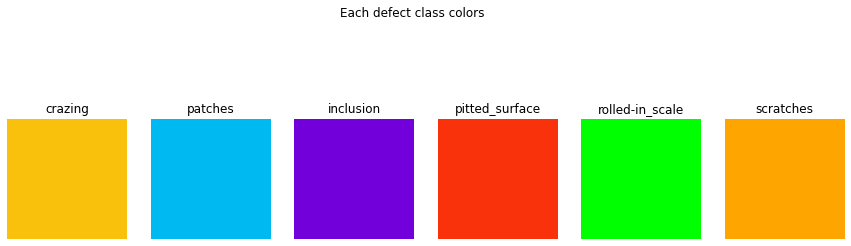

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.35s/it]


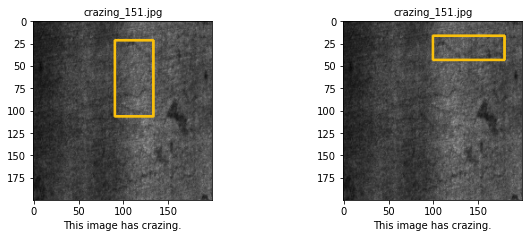

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.44s/it]


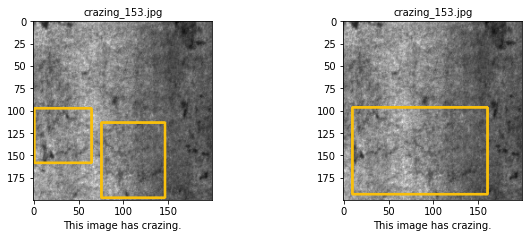

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]


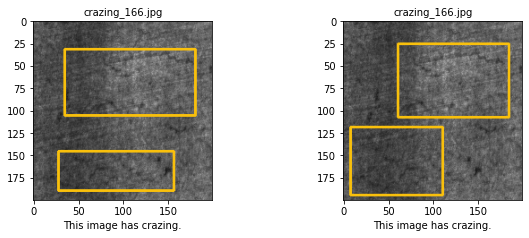

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.26s/it]


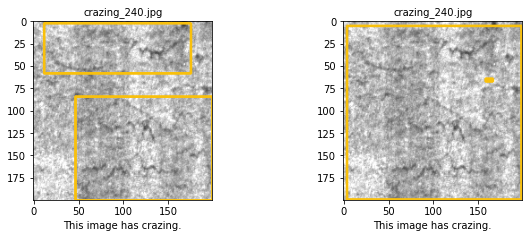

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/it]


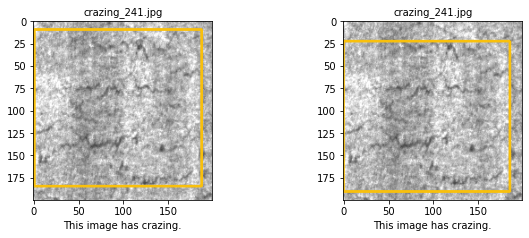

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


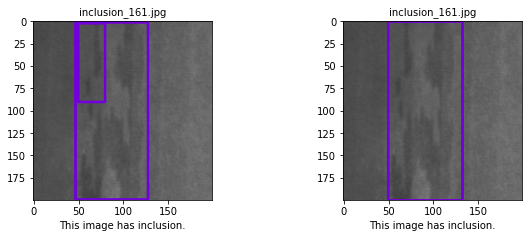

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]


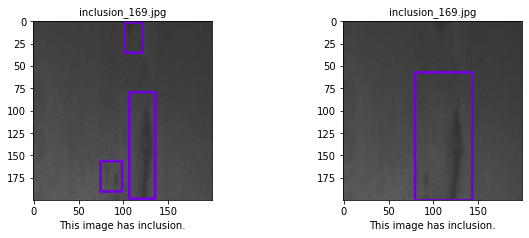

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


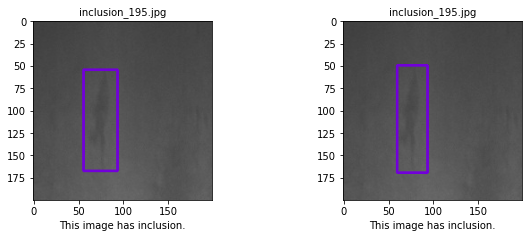

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.32s/it]


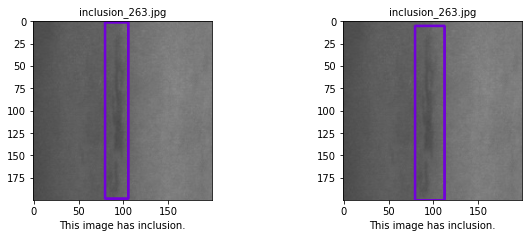

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.20s/it]


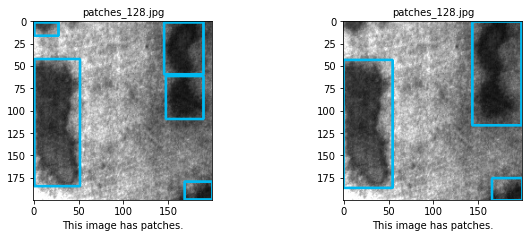

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.38s/it]


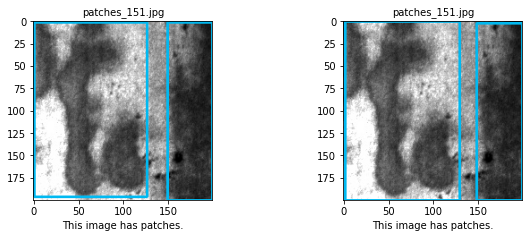

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/it]


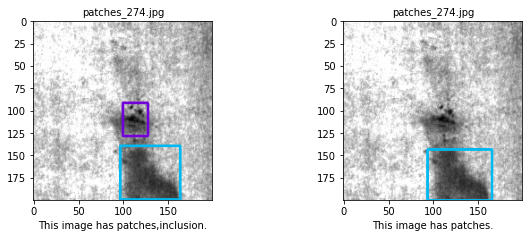

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.20s/it]


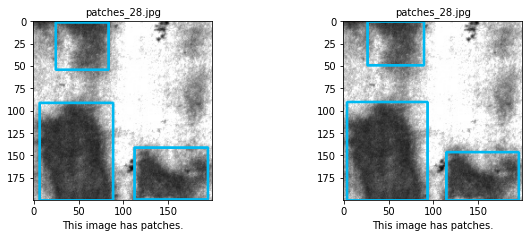

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


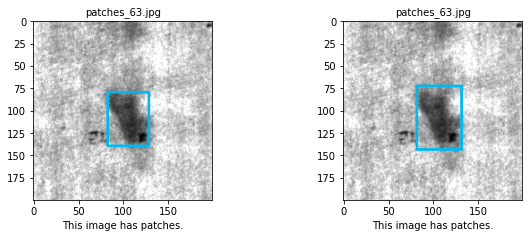

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


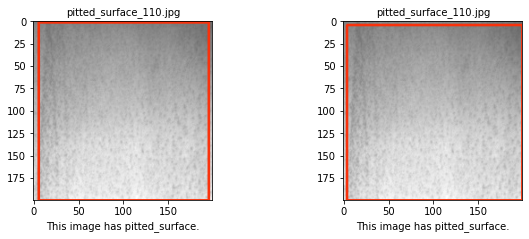

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


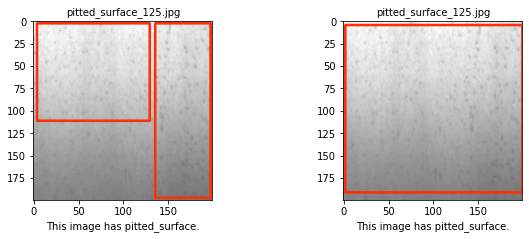

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


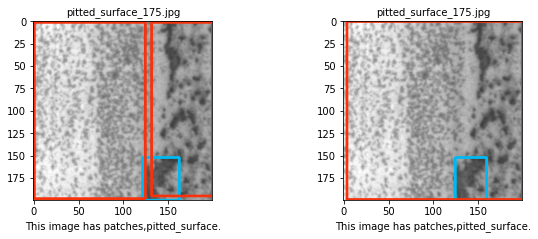

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.30s/it]


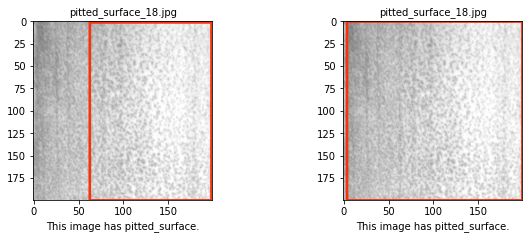

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.44s/it]


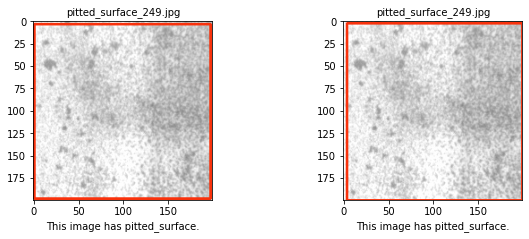

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.64s/it]


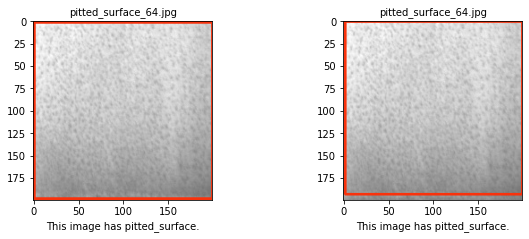

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


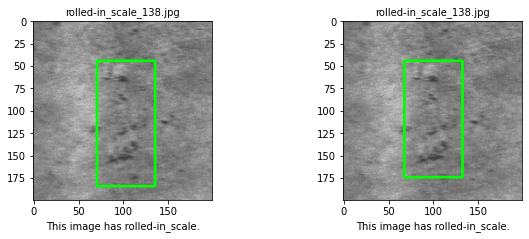

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/it]


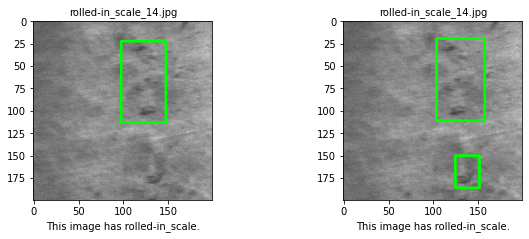

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.40s/it]


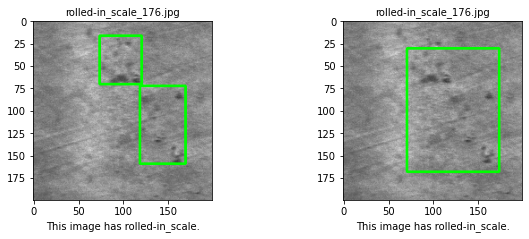

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]


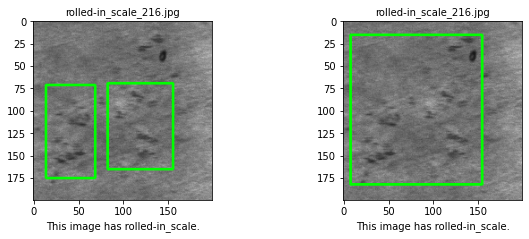

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.68s/it]


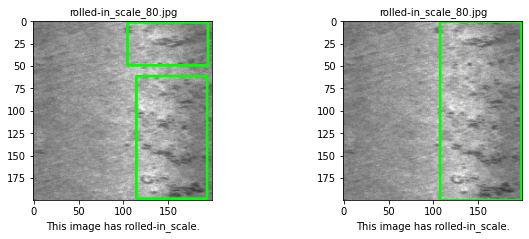

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/it]


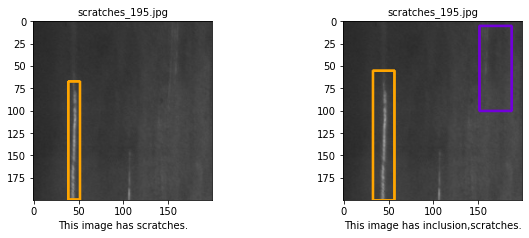

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.51s/it]


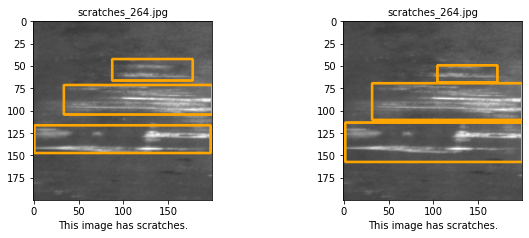

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


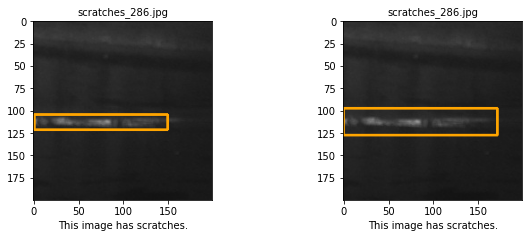

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


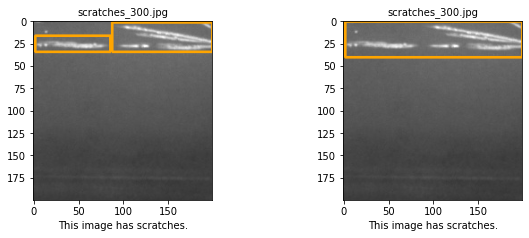

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]


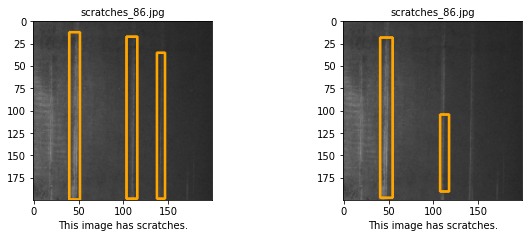

In [11]:
if __name__ == "__main__":
    main()